In [1]:
from cea_radiography import performance
from cea_radiography import evaluator
from cea_radiography import cea
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd

plt.rcParams["font.family"]= "Arial"
plt.rcParams["font.size"]= 12
plt.rcParams["svg.fonttype"] = "none"

# 01. Performance Calculation

In [2]:
examiner_df= pd.read_csv("../01_Data/master_dataset.csv")
ai_df= pd.read_csv("../01_Data/02_processed/dataset_ai_diagnosis_eval.csv")
gt_df= pd.read_csv("../01_Data/02_processed/dataset_groundtruth_eval.csv")

eval=performance.PerformanceConfig(
        ground_truth_col="ground_truth",
        diagnosis_col="diagnosis",
        groupby_cols=("examiner","ai_diagnosis"),
        passthrough_cols=("experience_level",),
        passthrough_reduce="mode",
        positive_label=1,
        negative_label=0,
        zero_division_value=0.0,
        enforce_binary=True
    )
Performanceval = performance.PerformanceEvaluator(eval)
examiner_performance_df=Performanceval.evaluate(examiner_df)
ai_performance_df=Performanceval.evaluate(ai_df)
ai_performance_df["ai_diagnosis"]=1

gt_performance_df=Performanceval.evaluate(gt_df)
gt_performance_df["ai_diagnosis"]=0

# 02. Cost-effectiveness Calculation

In [3]:
import pandas as pd

Cost_EUR = cea.Cost(
    intraoral_radiography = 14.64,
    cbct= 214.00,
    ai = 8,
    rct = 415.67,
    panoramic = 43.92,
    crown = 377.27,
    examination = 21.96)

config = cea.ModelConfig()

calculator = cea.CostEffectivenessCalculator(Cost_EUR)

calculator.fit_cost(examiner_performance_df)
calculator.fit_effectiveness()
examiner_df=calculator.result_

calculator.fit_cost(ai_performance_df)
calculator.fit_effectiveness()
ai_df=calculator.result_

calculator.fit_cost(gt_performance_df)
calculator.fit_effectiveness()
gt_df=calculator.result_

# Plots

/home/ewalter/Projects/Cost-Effectiveness/LBenz/CE_LB_04/src/cea_radiography/evaluator.py:383: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/ewalter/Projects/Cost-Effectiveness/LBenz/CE_LB_04/src/cea_radiography/evaluator.py:634: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(value)
/home/ewalter/Projects/Cost-Effectiveness/LBenz/CE_LB_04/src/cea_radiography/evaluator.py:388: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(
/home/ewalter/Projects/Cost-Effectiveness/LBenz/CE_LB_04/src/cea_radiography/evaluator.py:634: FutureWarning: Calling float on a single element Series is deprecated and will raise a T

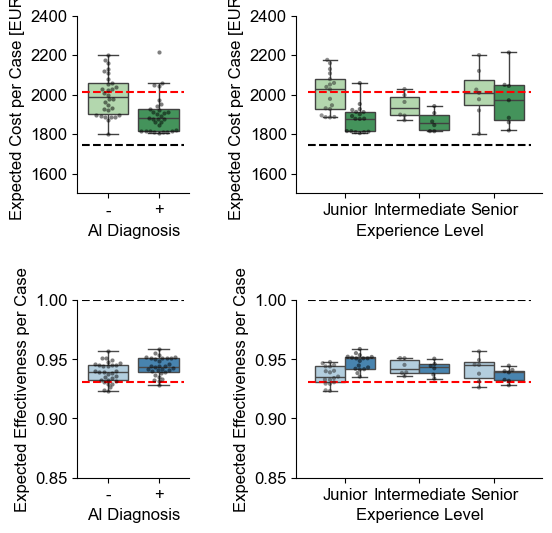

In [4]:
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(2, 2, width_ratios=[1, 2.2], wspace=0.6, hspace=0.6) 

blues= sns.color_palette("Blues", n_colors=2)
greens= sns.color_palette("Greens", n_colors=2)

ax_top_left = fig.add_subplot(gs[0])
ax_top_right = fig.add_subplot(gs[0,1:2])
ax_bottom_left = fig.add_subplot(gs[1, 0])
ax_bottom_right = fig.add_subplot(gs[1, 1:2])

evaluator.plot_cost(ax_top_left, examiner_df, x_col="ai_diagnosis", hue=None, baseline_gt=gt_df["cost_per_case"], exp_order=(0,1), x_label="AI Diagnosis", exp_labels=("-", "+"), baseline_ai=ai_df["cost_per_case"])
evaluator.plot_cost(ax_top_right, examiner_df, ylim=(1500,2400), baseline_gt=gt_df["cost_per_case"], baseline_ai=ai_df["cost_per_case"])
evaluator.plot_effectiveness(ax_bottom_left, examiner_df, x_col="ai_diagnosis", hue=None, ylim=(0.85,1), baseline_gt=gt_df["effectiveness_per_case"], exp_order=(0,1), x_label="AI Diagnosis", exp_labels=("-", "+"), baseline_ai=ai_df["effectiveness_per_case"])
evaluator.plot_effectiveness(ax_bottom_right, examiner_df, ylim=(0.85,1), baseline_gt=gt_df["effectiveness_per_case"], baseline_ai=ai_df["effectiveness_per_case"])

plt.savefig("cost_effectiveness_multipanel.svg", format="svg", bbox_inches="tight")

# ICER

In [5]:
icer=evaluator.calculate_delta_cost_effectiveness(examiner_df)
boots=evaluator.bootstrap_samples(icer, n=1000, random_state=42, label="all", mode="weighted", weights={0:0.4, 1:1.0, 2:0.85})
junior_boots=evaluator.bootstrap_samples(icer[icer["experience_level"]==0], n=1000, random_state=42, label="junior")
intermediate_boots=evaluator.bootstrap_samples(icer[icer["experience_level"]==1], n=1000, random_state=42, label="intermediate")
senior_boots=evaluator.bootstrap_samples(icer[icer["experience_level"]==2], n=1000, random_state=42, label="senior")
experience_boots_df=pd.concat([junior_boots,intermediate_boots,senior_boots])

experience_boots_df["delta_effectiveness"]=experience_boots_df["delta_effectiveness"]*100
boots["delta_effectiveness"]=boots["delta_effectiveness"]*100

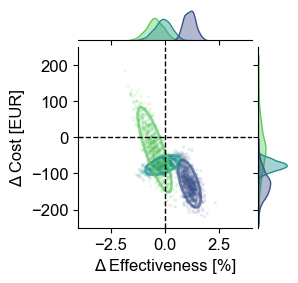

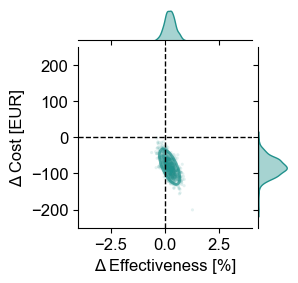

In [6]:
g = evaluator.plot_ce_plane_jointgrid(
    experience_boots_df,
    palette="viridis",
    height=3,
    draw_ellipses=True,
    hue="experience_level",
    hue_order=["junior","intermediate","senior"],
    ellipse_n_std=1.95,
    xlim=(-4, 4),
    ylim=(-250, 250),
    xlabel="Δ Effectiveness [%]",
    ylabel="Δ Cost [EUR]",
    show_scatter_legend=False,
    savepath="cost_effectiveness_CEplane.svg"
)

g = evaluator.plot_ce_plane_jointgrid(
    boots,
    palette="viridis",
    height=3,
    draw_ellipses=True,
    hue="experience_level",
    hue_order=["all"],
    ellipse_n_std=1.95,
    xlim=(-4, 4),
    ylim=(-250, 250),
    xlabel="Δ Effectiveness [%]",
    ylabel="Δ Cost [EUR]",
    show_scatter_legend=False,
    savepath="cost_effectiveness_CEplane_all.svg")